In [1]:
from shearletNN.shearlets import getcomplexshearlets2D
from shearletNN.shearlet_utils import (
    frequency_shearlet_transform,
    spatial_shearlet_transform,
    ShearletTransformLoader,
    shifted_frequency_shearlet_transform,
    shifted_batched_frequency_reconstruction,
    batched_reconstruction,
    batched_spatial_coefficients,
    spatial_shearlet_transform,
)
from shearletNN.complex_resnet import (
    complex_resnet18,
    complex_resnet34,
    complex_resnet50,
)
from shearletNN.layers import CGELU, CReLU

import torch
import torchvision
from torchvision.transforms import v2
from torchvision import transforms

import gc
from tqdm import tqdm


patch_size = 128
image_size = 128

rows, cols = image_size, image_size


shearlets, shearletIdxs, RMS, dualFrameWeights = getcomplexshearlets2D(
    rows,
    cols,
    1,
    3,
    1,
    0.5,
    wavelet_eff_support=image_size,
    gaussian_eff_support=image_size,
)

shearlets = torch.tensor(shearlets).permute(2, 0, 1).type(torch.complex64).to(0)
dualFrameWeights = torch.tensor(dualFrameWeights).to(0)

In [2]:
def train(model, optimizer, loader, accumulate=1):
    model.train()
    loss = torch.nn.CrossEntropyLoss()

    for i, (X, y) in tqdm(enumerate(loader)):
        out = model(X.to(0))
        optimizer.zero_grad()
        l = loss(out, y.to(0)) / accumulate
        l.backward()
        if i % accumulate == (accumulate - 1):
            optimizer.step()
        

def accuracy(output, target, topk=(1,)):
    output = output.to(torch.device('cpu'))
    target = target.to(torch.device('cpu'))
    maxk = max(topk)
    batch_size = target.shape[0]

    _, idx = output.sort(dim=1, descending=True)
    pred = idx.narrow(1, 0, maxk).t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(dim=0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def epoch_accuracy(loader_s, student):
    student.eval()

    out_epoch_s = [accuracy(student(L.to(0)), y)[0].detach().cpu().item() for L, y in loader_s]

    student.train()

    return sum(out_epoch_s) / len(out_epoch_s)

def test(network, test_loader):
    network.eval().to(0)
    test_loss = 0
    correct = 0
    total = 0
    test_losses=[]
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.to(0))
            test_loss += torch.nn.CrossEntropyLoss()(output, target.to(0)).item()
            pred = output.data.max(1, keepdim=True)[1].cpu()
            correct += pred.eq(target.data.view_as(pred)).sum()
            total += target.shape[0]
        test_loss /= total
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, total,
        100. * correct / total))

class IndexSubsetDataset:
    def __init__(self, ds, inds):
        self.ds = ds
        self.inds = inds

    def __iter__(self):
        for i in range(len(self.inds)):
            yield self[i]
    
    def __getitem__(self, i):
        return self.ds[self.inds[i]]
    
    def __len__(self):
        return len(self.inds)
    

def linearleaves(module):
    # returns a list of pairs of (parent, submodule_name) pairs for all submodule leaves of the current module
    if isinstance(module, torch.nn.Linear):
        return [(module, None)]

    linear_children = []
    for name, mod in module.named_modules():
        if isinstance(mod, torch.nn.Linear):
            linear_children.append((name, module))
    return linear_children

In [3]:
def linearleaves(module):
    # returns a list of pairs of (parent, submodule_name) pairs for all submodule leaves of the current module
    if isinstance(module, torch.nn.Linear):
        return [(module, None)]

    linear_children = []
    for name, mod in module.named_modules():
        if isinstance(mod, torch.nn.Linear) or isinstance(mod, torch.nn.Conv2d):
            linear_children.append((name, module))
    return linear_children
        

def getattrrecur(mod, s):
    s = s.split('.')
    for substr in s:
        mod = getattr(mod, substr)
    return mod


def setattrrecur(mod, s, value):
    s = s.split('.')
    for substr in s[:-1]:
        mod = getattr(mod, substr)
    setattr(mod, s[-1], value)


def spectral_normalize(model):
    for name, mod in linearleaves(model):
        setattrrecur(model, name, torch.nn.utils.parametrizations.spectral_norm(getattrrecur(mod, name)))
    
    return model

In [4]:
batch_size_train = 128

In [5]:
import matplotlib.pyplot as plt


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]

train_transform = v2.Compose([
    transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
    # transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    repeat3,
])

val_transform = v2.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    repeat3,
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

ds_train = torchvision.datasets.Caltech101('./', transform=train_transform, download = True)
ds_train = IndexSubsetDataset(ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], []))

ds_val = torchvision.datasets.Caltech101('./', transform=val_transform, download = True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])

train_loader = torch.utils.data.DataLoader(
  ds_train,
  batch_size=batch_size_train, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(
  ds_val,
  batch_size=batch_size_train, shuffle=False)
"""
shearlets = shearlets

def shearlet_transform(img):
    return spatial_shearlet_transform(img.to(0), shearlets.to(0), patch_size)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
  ds_val,
  batch_size=batch_size_train, shuffle=False)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [batch_size_train, shearlets.shape[0] * 3, image_size, image_size], x.shape
    plt.imshow(x[0][0].real.cpu().numpy())
    plt.show()
    b = batched_reconstruction(x[:, :3], shearlets, dualFrameWeights)
    plt.imshow(b[0].cpu().numpy())
    plt.show()
    break

"""

Files already downloaded and verified
Files already downloaded and verified


'\nshearlets = shearlets\n\ndef shearlet_transform(img):\n    return spatial_shearlet_transform(img.to(0), shearlets.to(0), patch_size)\n\ntrain_loader = ShearletTransformLoader(train_loader, shearlet_transform)\n\nval_loader = torch.utils.data.DataLoader(\n  ds_val,\n  batch_size=batch_size_train, shuffle=False)\n\nval_loader = ShearletTransformLoader(val_loader, shearlet_transform)\n\nfor x, y in tqdm(train_loader):\n    assert list(x.shape) == [batch_size_train, shearlets.shape[0] * 3, image_size, image_size], x.shape\n    plt.imshow(x[0][0].real.cpu().numpy())\n    plt.show()\n    b = batched_reconstruction(x[:, :3], shearlets, dualFrameWeights)\n    plt.imshow(b[0].cpu().numpy())\n    plt.show()\n    break\n\n'

In [16]:
import numpy as np
from shearletNN.shearlet_utils import suppress_square

def suppress_upper(img, size=32):
    print(img.shape)

    img[..., :size, -size:] = 0

    return img

# this operation has some numerical instability in the torch version which is intolerable at single precision.
def sparse_shearenc2D(X, shearlets):
    fftlib = torch.fft
    fftlib1 = np.fft

    X1, shearlets1 = X.cpu().numpy(), shearlets.permute(1, 2, 0).cpu().numpy()

    #skipping useGPU stuff...
    coeffs = torch.zeros(shearlets.shape, dtype=torch.complex128)
    coeffs1 = np.zeros(shearlets1.shape, dtype=complex)

    # get data in frequency domain
    Xfreq = fftlib.fft2(X.type(torch.float64))
    Xfreq1 = fftlib1.fft2(X1)

    if not torch.allclose(Xfreq, torch.tensor(Xfreq1).type(torch.complex128)):
        print('fft2 output not close', torch.abs(Xfreq - torch.tensor(Xfreq1).type(torch.complex128)).max())

    Xfreq = fftlib.fftshift(Xfreq, dim=(-2, -1))

    patch_size = 124

    # Xfreq = suppress_square(Xfreq, (Xfreq.shape[-1] - patch_size) // 2)

    Xfreq = fftlib.ifftshift(Xfreq, dim=(-2, -1))

    Xfreq = suppress_upper(Xfreq, patch_size)

    print('sparsity: ', (Xfreq == 0).sum() / Xfreq.flatten().shape[0])

    plt.imshow(Xfreq != 0, cmap='gray', vmax=1, vmin=0)
    plt.show()

    values = Xfreq * torch.conj(shearlets[0])
    values = values.real
    values = values - values.min()
    values = values / values.max()


    plt.imshow(values, cmap='gray', vmax=1, vmin=0)
    plt.show()

    # TODO: use torch so we can vectorize even this process
    for j in range(shearlets.shape[0]):
        coeffs[j] = fftlib.ifft2(Xfreq * torch.conj(shearlets[j]))

    for j in range(shearlets1.shape[-1]):
        coeffs1[:,:,j] = fftlib1.ifft2(Xfreq1 * np.conj(shearlets1[:,:,j]))

    if not torch.allclose(coeffs, torch.tensor(coeffs1).type(torch.complex128).permute(2, 0, 1)):
        print('coeff mul not close', torch.abs(coeffs - torch.tensor(coeffs1).type(torch.complex128).permute(2, 0, 1)).max())


    return coeffs, coeffs1


def npsheardec2D(X, shearlets):
    fftlib = np.fft
    #skipping useGPU stuff...
    coeffs = np.zeros(shearlets.shape, dtype=complex)

    # get data in frequency domain
    Xfreq = fftlib.fft2(X)
    # print('frequency domain')
    # visual.complexImageShow(Xfreq / Xfreq.max())
    # plt.show()

    # compute shearlet coefficients at each scale
    # note that pointwise multiplication in the fourier domain equals
    # convolution in the time-domain
    for j in range(shearlets.shape[-1]):
        coeffs[:,:,j] = fftlib.ifft2(Xfreq * np.conj(shearlets[:,:,j]))

    return coeffs


def sparse_sheardec2D(coeffs, shearlets, dualFrameWeights):
    fftlib = torch.fft
    fftlib1 = np.fft
    coeffs1, shearlets1, dualFrameWeights1 = coeffs.permute(1, 2, 0).numpy(), shearlets.permute(1, 2, 0).numpy(), dualFrameWeights.numpy()
    # skipping useGPU stuff...
    X = torch.zeros((coeffs.shape[-2], coeffs.shape[-1]), dtype=torch.complex128)
    X1 = np.zeros((coeffs1.shape[0], coeffs1.shape[1]), dtype=complex)

    for j in range(shearlets.shape[0]):
        X = X + fftlib.fft2(coeffs[j]) * shearlets[j]

    for j in range(shearlets1.shape[-1]):
        X1 = X1 + fftlib1.fft2(coeffs1[:,:,j]) * shearlets1[:,:,j]

    if not torch.allclose(X, torch.tensor(X1).type(torch.complex128)):
        print('shearlet sum not close', torch.abs(X - torch.tensor(X1).type(torch.complex128)).max())

    InversedualFrameWeights = 1 / dualFrameWeights
    InversedualFrameWeights[InversedualFrameWeights==torch.inf] = 0.0

    InversedualFrameWeights1 = 1 / dualFrameWeights1
    InversedualFrameWeights1[InversedualFrameWeights1==np.inf] = 0.0

    if not torch.allclose(InversedualFrameWeights, torch.tensor(InversedualFrameWeights1)):
        print('inverse weights not close')

    X = fftlib.ifft2((X * InversedualFrameWeights))
    X1 = fftlib1.ifft2((X1 * InversedualFrameWeights1))

    if  not torch.allclose(X.real, torch.tensor(X1).real):
        print('result not close', torch.isclose(X.real, torch.tensor(X1).real).sum(), torch.abs(X - torch.tensor(X1).type(torch.complex128)).max(), torch.isclose(InversedualFrameWeights, torch.tensor(InversedualFrameWeights1)).sum())

    return X.real, np.real(X1)


def npshearrec2D(coeffs, shearlets, dualFrameWeights):
    fftlib = np.fft
    # skipping useGPU stuff...
    X = np.zeros((coeffs.shape[0], coeffs.shape[1]), dtype=complex)

    for j in range(shearlets.shape[-1]):
        X = X + fftlib.fft2(coeffs[:,:,j]) * shearlets[:,:,j]

    InversedualFrameWeights = 1 / dualFrameWeights
    InversedualFrameWeights[InversedualFrameWeights==np.inf] = 0.0

    X = fftlib.ifft2((X*InversedualFrameWeights))

    return np.real(X)

In [17]:
for x, y in tqdm(train_loader):
    break
img = x[12,0].cpu()

  0%|          | 0/55 [00:00<?, ?it/s]


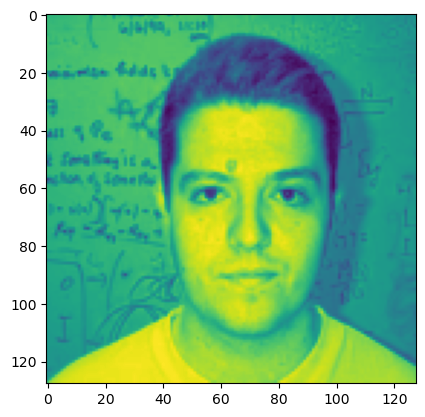

In [18]:
plt.imshow(img.real)

torch.Size([128, 128])
sparsity:  tensor(0.9385)


/tmp/ipykernel_1325237/1177644423.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded, np_encoded = sparse_shearenc2D(torch.tensor(img), shearlets.cpu())


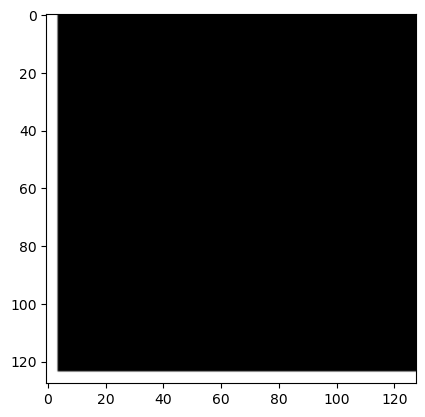

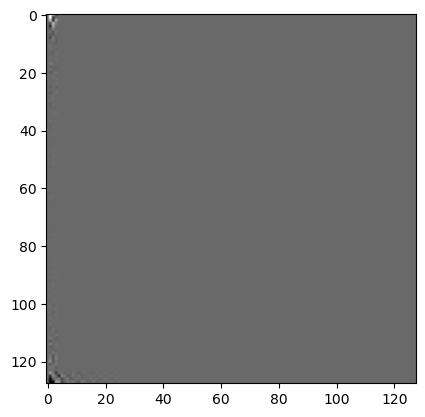

coeff mul not close tensor(0.1349, dtype=torch.float64)


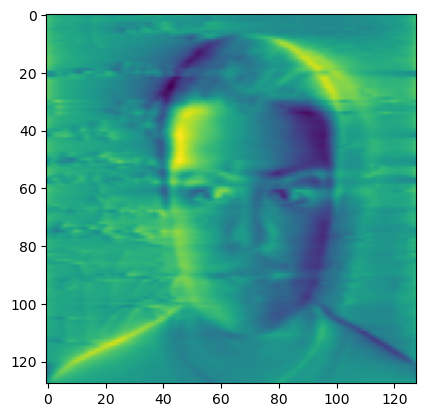

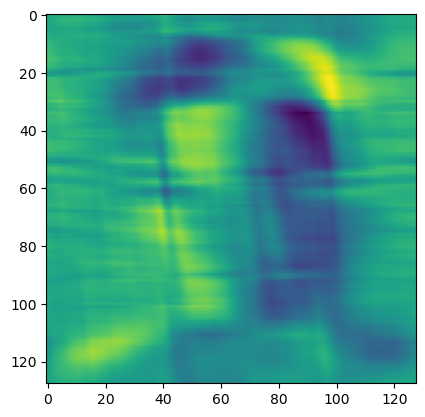

(<matplotlib.image.AxesImage at 0x7f119031e4c0>,
 0.13068633398939108,
 -0.13021631006275147)

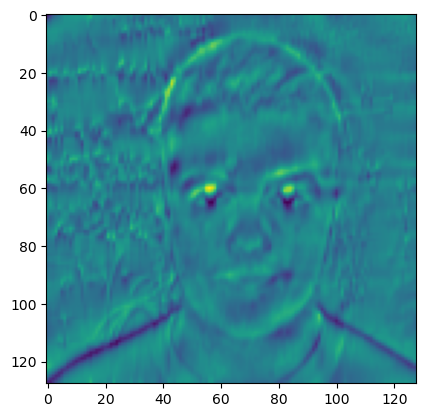

In [19]:
encoded, np_encoded = sparse_shearenc2D(torch.tensor(img), shearlets.cpu())
plt.imshow(np.real(np_encoded)[..., 0])
plt.show()
plt.imshow(encoded.real[0])
plt.show()
delta = encoded.permute(1, 2, 0).real.numpy() - np.real(np_encoded)
plt.imshow(delta.sum(-1)), delta.max(), delta.min()

result not close tensor(0) tensor(0.0286, dtype=torch.float64) tensor(16384)


/tmp/ipykernel_1325237/386295583.py:107: RuntimeWarning: divide by zero encountered in divide
  InversedualFrameWeights1 = 1 / dualFrameWeights1


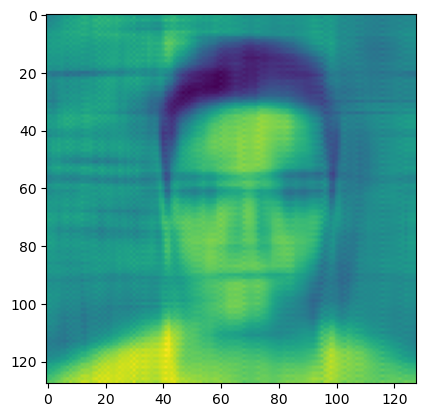

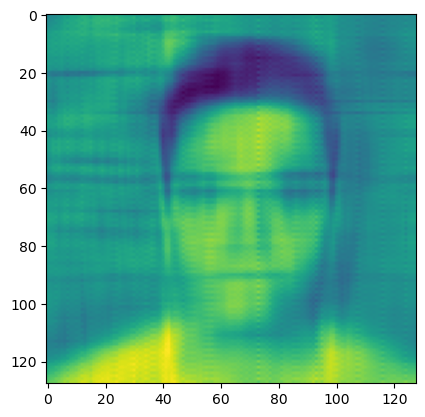

In [20]:
decoded, np_decoded = sparse_sheardec2D(encoded, shearlets.cpu(), dualFrameWeights.cpu())
plt.imshow(decoded)
plt.show()
plt.imshow(np_decoded)
plt.show()


/tmp/ipykernel_1325237/386295583.py:130: RuntimeWarning: divide by zero encountered in divide
  InversedualFrameWeights = 1 / dualFrameWeights


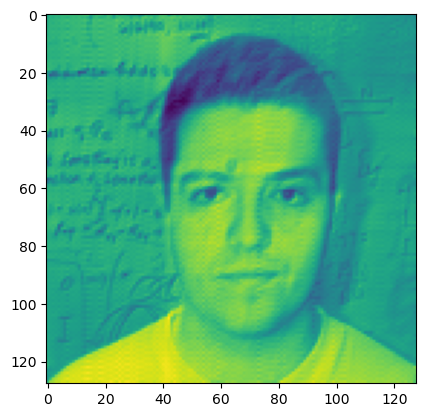

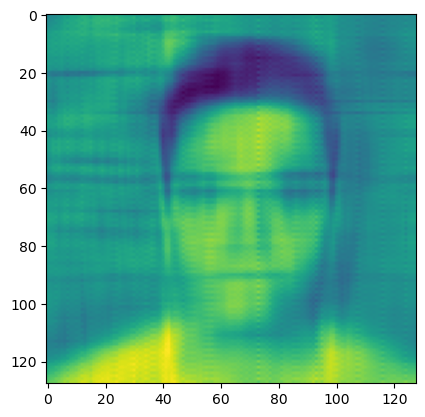

In [21]:
plt.imshow(npshearrec2D(np_encoded, shearlets.permute(1, 2, 0).cpu().numpy(), dualFrameWeights.cpu().numpy()))
plt.show()
plt.imshow(npshearrec2D(encoded.permute(1, 2, 0).numpy(), shearlets.permute(1, 2, 0).cpu().numpy(), dualFrameWeights.cpu().numpy()))
plt.show()

/tmp/ipykernel_1325237/386295583.py:107: RuntimeWarning: divide by zero encountered in divide
  InversedualFrameWeights1 = 1 / dualFrameWeights1


result not close tensor(0) tensor(0.0315, dtype=torch.float64) tensor(16384)


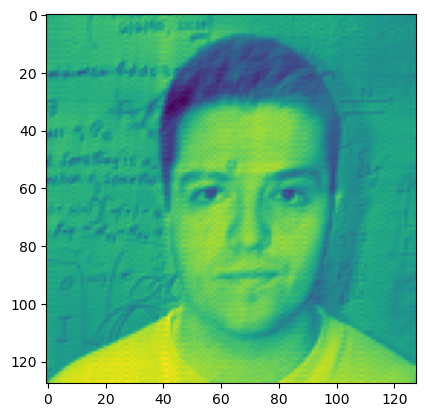

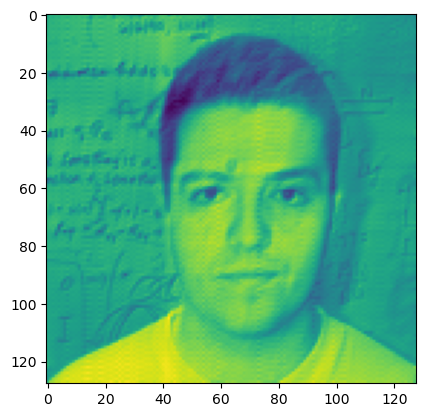

In [22]:
decoded, np_decoded = sparse_sheardec2D(torch.tensor(np_encoded).permute(2, 0, 1), shearlets.cpu(), dualFrameWeights.cpu())
plt.imshow(decoded)
plt.show()
plt.imshow(np_decoded)

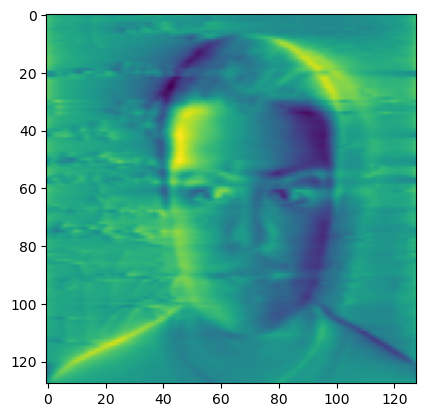

/tmp/ipykernel_1325237/386295583.py:130: RuntimeWarning: divide by zero encountered in divide
  InversedualFrameWeights = 1 / dualFrameWeights


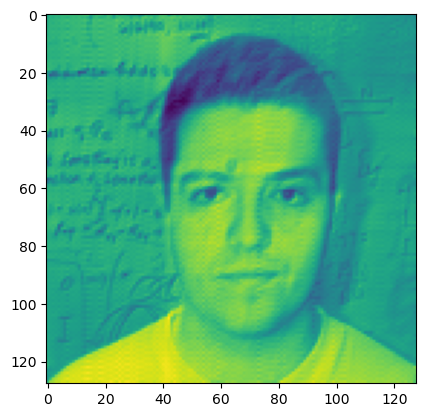

In [23]:
np_encoded = npsheardec2D(img.numpy(), shearlets.permute(1, 2, 0).cpu().numpy())
plt.imshow(np.real(np_encoded)[..., 0])
plt.show()
np_decoded = npshearrec2D(np_encoded, shearlets.permute(1, 2, 0).cpu().numpy(), dualFrameWeights.cpu().numpy())
plt.imshow(np_decoded)

In [24]:
torch.allclose(torch.tensor(encoded).type(torch.complex128).permute(1, 2, 0), torch.tensor(np_encoded).type(torch.complex128)), torch.allclose(torch.tensor(decoded).type(torch.complex128), torch.tensor(np_decoded).type(torch.complex128))

/tmp/ipykernel_1325237/1576137348.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.allclose(torch.tensor(encoded).type(torch.complex128).permute(1, 2, 0), torch.tensor(np_encoded).type(torch.complex128)), torch.allclose(torch.tensor(decoded).type(torch.complex128), torch.tensor(np_decoded).type(torch.complex128))


(False, False)

In [25]:
encoded, np_encoded = torch.tensor(encoded).type(torch.complex128).permute(1, 2, 0), torch.tensor(np_encoded).type(torch.complex128)
decoded, np_decoded = torch.tensor(decoded).type(torch.complex128), torch.tensor(np_decoded).type(torch.complex128)

torch.abs(encoded - np_encoded).max(), torch.abs(decoded - np_decoded).max()

/tmp/ipykernel_1325237/3297081687.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded, np_encoded = torch.tensor(encoded).type(torch.complex128).permute(1, 2, 0), torch.tensor(np_encoded).type(torch.complex128)
/tmp/ipykernel_1325237/3297081687.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded, np_decoded = torch.tensor(decoded).type(torch.complex128), torch.tensor(np_decoded).type(torch.complex128)


(tensor(0.1349, dtype=torch.float64), tensor(0.0250, dtype=torch.float64))